**Asif Arman Rahman**
***

# Ans. 1
***

## Description


| Variable |                 Definition                 |                      Key                       |
| :------: | :----------------------------------------: | :--------------------------------------------: |
| survival |                   Survival	                |                0 = No, 1 = Yes                 |
|  pclass  |                 Ticket class               |            1 = 1st, 2 = 2nd, 3 = 3rd           |
|   sex    |	                 Sex	                |                                                |
|   Age    |                 Age in years	            |                                                |
|  sibsp   | # of siblings / spouses aboard the Titanic	|                                                |
|  parch   | # of parents / children aboard the Titanic	|                                                |
|  ticket  |                Ticket number           	|                                                |
|   fare   |               Passenger fare           	|                                                |
|   cabin  |                Cabin number            	|                                                |
| embarked |              Port of Embarkation           | C = Cherbourg, Q = Queenstown, S = Southampton |




### Variable Notes

**pclass:** A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


### Dataset

The dataset is available at this link [Titanic](https://www.kaggle.com/c/titanic)

In [1]:
#import library

%matplotlib inline

import re
import warnings
import pandas as pd
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


warnings.filterwarnings('ignore')

#  Ans. 2
***


**i.** Print Data

**ii.** Visulaize Data

**iii.** Number of Attributes

**iv.** Number of Records

**v.** Handling Missing Data (if there's any)

In [2]:
# Load Data

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
# Print data

display(train.head(2))
display(test.head(2))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


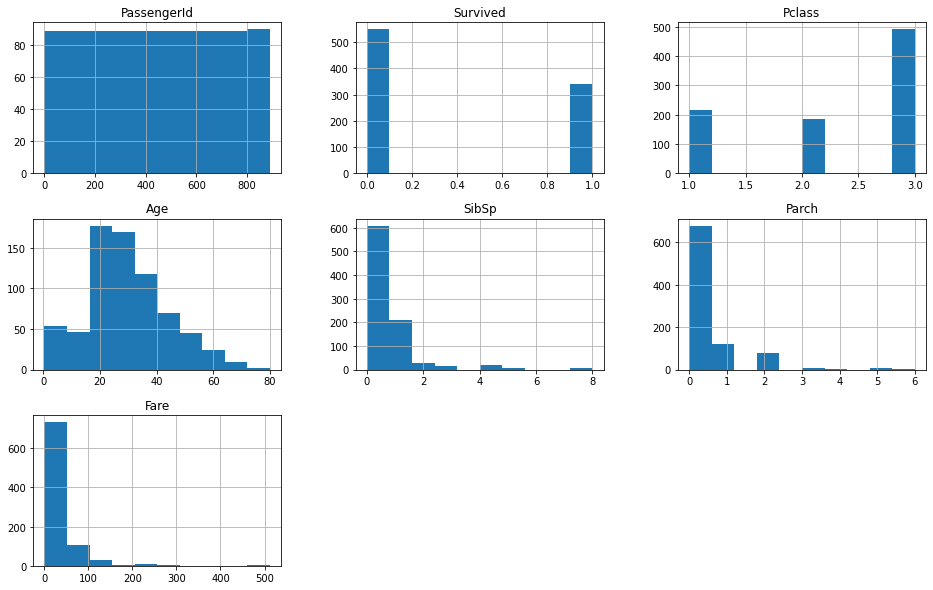

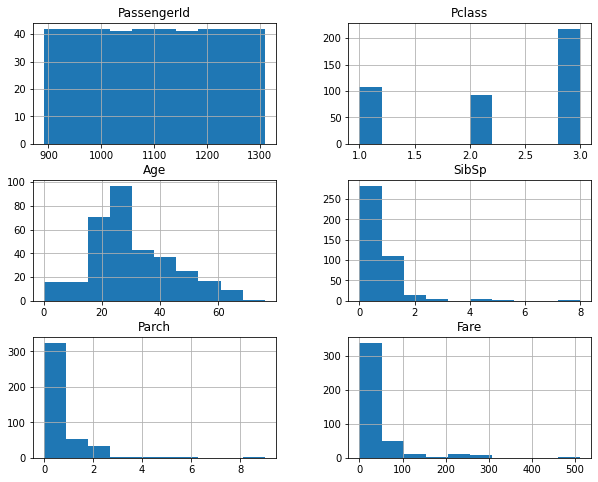

In [4]:
# Visualize

train.hist(figsize = (16, 10))
plt.show()

test.hist(figsize = (10, 8))
plt.show()

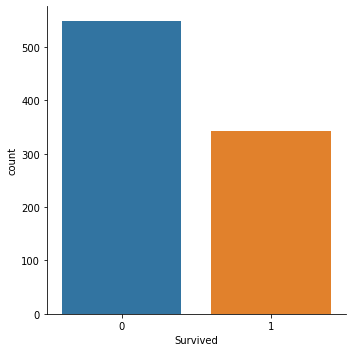

In [5]:
### Survived Plot
sns.factorplot('Survived', data = train, kind = 'count')
plt.show()

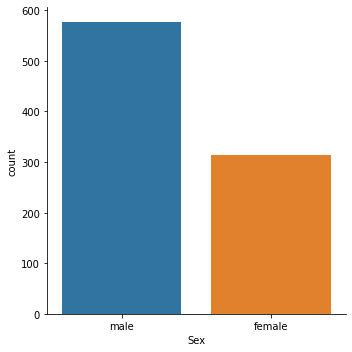

In [6]:
### Gender Plot
sns.factorplot('Sex', data = train, kind = 'count')
plt.show()

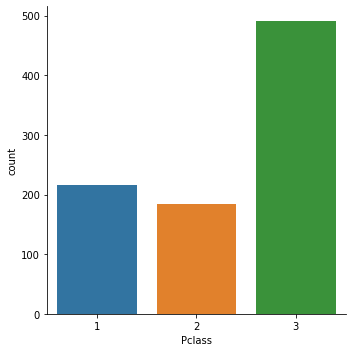

In [7]:
### Class plot
sns.factorplot('Pclass', data = train, kind = 'count')
plt.show()

In [8]:
# number of records and attributes

display(train.shape)
display(test.shape)

(891, 12)

(418, 11)

In [9]:
# Missing data

print('Train:')
display(train.isnull().sum())

print('Test:')
display(test.isnull().sum())

Train:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test:


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

These will require Handling.

Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.

Cabin > Age are incomplete in case of test dataset.

As Cabin has huge data loss, it can't be filled, we'll use it later in another way.

In [10]:
#filling missing values 'Age' by median

train.Age= train.Age.fillna(train.Age.median()) 
test.Age= test.Age.fillna(test.Age.median()) 

In [11]:
#filling missing values 'Fare' by mean

test.Fare= test.Fare.fillna(train.Fare.mean()) 

In [12]:
display(train.Embarked.value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
#filling missing values 'Embarked' by the hightest number of value

train.Embarked= train["Embarked"].fillna('S') 

# Ans. 3
***

From the correlation Graph it can be discovered that:

* **Parch** has the most effect on the output.
* Next one is **Age**.
* The ones after these two don't have as huge effect as these two. 

In [14]:
column_names = train.columns

display(column_names)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [15]:
# Reodering columns

reorder = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

train = train[reorder]

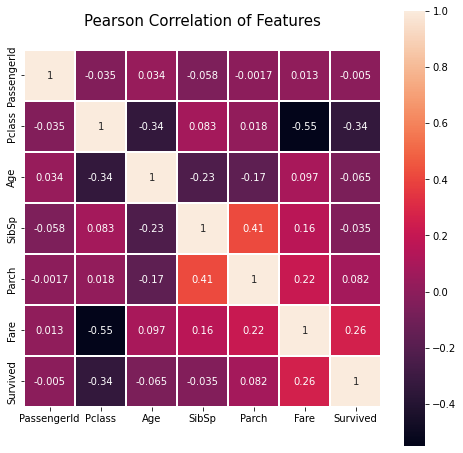

In [16]:
# Correlation Matrix

plt.figure(figsize=(8,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.corr(), linewidths=0.1, square=True, annot=True)
plt.show()

# Ans. 4
***

New attribute/feature from existing attributes

i.    Title

ii.   HasCabin

iii.  FamilySize

iv.   IsAlone

v.    Sex

vi.   Age

vii.  Embarked

viii. Fare

In [17]:
full_data = [train, test]



# Create a new feature Title, containing the titles of passenger names, because names on it's own had no contribution before

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    # If the title exists, extract and return it.
    
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')     # Group all non-common titles into one single grouping "Rare"
    
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in full_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train.Title = train.Title.astype(int)
test.Title = test.Title.astype(int)




# Feature that tells whether a passenger had a cabin on the Titanic, this way we'll assume the missing values in cabin means they had no cabin

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)




# Create new feature FamilySize as a combination of SibSp and Parch

for dataset in full_data:
    
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



# Create new feature IsAlone from FamilySize

for dataset in full_data:
    
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1



# Mapping Sex
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


# Mapping Age
for dataset in full_data:

    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

train.Age = train.Age.astype(int)
test.Age = test.Age.astype(int)




# Mapping Embarked

for dataset in full_data:

    dataset.Embarked = dataset.Embarked.map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)



# Mapping Fare

for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [18]:
### dropping attributes

train = train.drop(columns = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'FamilySize'], axis=1)
train.head()

,Pclass,Sex,Age,Fare,Embarked,Survived,Title,Has_Cabin,IsAlone
0,3,0,1,0,0,0,1,0,0
1,1,1,2,3,1,1,3,1,0
2,3,1,1,1,0,1,2,0,1
3,1,1,2,3,0,1,3,1,0
4,3,0,2,1,0,0,1,0,1


In [19]:
### dropping attributes

test = test.drop(columns = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'FamilySize'], axis=1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,Has_Cabin,IsAlone
0,892,3,0,2,0,2,1,0,1
1,893,3,1,2,0,0,3,0,0
2,894,2,0,3,1,2,1,0,1
3,895,3,0,1,1,0,1,0,1
4,896,3,1,1,1,0,3,0,0


# Ans. 5
***

a) Split data

b) Apply Models:


     i)  Decision Tree Classifier

    ii)  Random Forest Classifier

    iii) Linear Regression Classifier

In [20]:
#Split data

Y_train = train["Survived"]
X_train = train.drop("Survived", axis=1)

In [21]:
test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
       'Has_Cabin', 'IsAlone'],
      dtype='object')

In [22]:
rcol = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'Has_Cabin', 'IsAlone']

X_test  = test[rcol]
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [23]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_DS = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Decision Tree Classifier accurary: %.3f" % (acc_decision_tree))

Decision Tree Classifier accurary: 87.880


In [24]:
# Random Forrest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RF = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print("Random Forrest Classifier accurary: %.3f" % (acc_random_forest))

Random Forrest Classifier accurary: 87.880


In [25]:
# Linear Regression
 
linear_regression = LinearRegression()
linear_regression.fit(X_train, Y_train)
Y_pred_LR = linear_regression.predict(X_test)

acc_linear_regression = round(linear_regression.score(X_train, Y_train) * 100, 2)
print("Linear Regression accurary: %.3f" % (acc_linear_regression))

Linear Regression accurary: 40.450


# Ans. 6
***

* Perform cross validation

> Random Forrest model is best.

In [26]:
# Cross Validation

cv = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)

## Decision Tree
scoresDS = cross_val_score(decision_tree, X_train, Y_train, scoring = 'accuracy', cv = cv, n_jobs = 1)
print('Accuracy for Decision Tree Classifier Model: %.3f (%.3f)' % (mean(scoresDS), std(scoresDS)))

## Random Forrest
scoresRF = cross_val_score(random_forest, X_train, Y_train, scoring = 'accuracy', cv = cv, n_jobs = 1)
print('Accuracy for Random Forest Model: %.3f (%.3f)' % (mean(scoresRF), std(scoresRF)))

## Linear Regression
scoresLR = cross_val_score(linear_regression, X_train, Y_train, scoring = 'accuracy', cv = cv, n_jobs = 1)
print('Accuracy for Linear Regression Model: %.3f (%.3f)' % (mean(scoresLR), std(scoresLR)))

Accuracy for Decision Tree Classifier Model: 0.802 (0.024)
Accuracy for Random Forest Model: 0.819 (0.027)
Accuracy for Linear Regression Model: nan (nan)


# Ans. 7
***

* Grid Search to further fine tune model.

> Fine tuning decrease prediction performance from 87.88 to 86.31

In [27]:
# instantiate base random forest model class
rf = RandomForestClassifier(random_state=0)

# define gridsearch parameters
param_grid = {'criterion': ['gini', 'entropy'], 'n_estimators': [200, 300, 500], 'max_features': ['auto', 'log2'],
              'max_depth': [5, 7, 9], 'min_samples_split': [6, 8, 10], 'min_samples_leaf': [6, 8, 10]}

# instantiate gridsearchcv class
rfgs = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 3, n_jobs = -1)

# fit model
rfgs.fit(X_train, Y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [200, 300, 500]},
             verbose=3)

In [28]:
rfgs.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'n_estimators': 300}

In [29]:
#Random Forrest

rf1=RandomForestClassifier(random_state = 42, criterion = 'entropy', max_depth = 7, max_features = 'auto', n_estimators = 300)

rf1.fit(X_train, Y_train)
Y_pred_GSRF = rf1.predict(X_test)
rf1.score(X_train, Y_train)
acc_random_forest_GS = round(rf1.score(X_train, Y_train) * 100, 2)
acc_random_forest_GS

86.31

In [30]:
scoresGSRF = cross_val_score(rf1, X_train, Y_train, scoring = 'accuracy', cv = cv, n_jobs = 1)
print('Accuracy for Random Forest Model: %.3f (%.3f)' % (mean(scoresGSRF), std(scoresGSRF)))

Accuracy for Random Forest Model: 0.816 (0.037)


# Submission

In [31]:
output = pd.DataFrame(test['PassengerId'])
output['Survived'] = Y_pred_RF

In [32]:
output.to_csv('submission.csv', index = False)